In [0]:
# https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

from sklearn.externals import joblib

finalMergedDF = joblib.load('finalMergedDF_noOutputs3.pkl') 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from sklearn.preprocessing import MinMaxScaler

from pandas import DataFrame
from pandas import concat

from keras.models import Sequential
from keras.layers import LSTM 
from keras.layers import Dense
from keras.optimizers import Adam
import keras.backend as K
 
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

del finalMergedDF['time']

cols = list(finalMergedDF)
cols.insert(0, cols.pop(cols.index('mood')))
finalMergedDF = finalMergedDF.loc[:,cols]

values = finalMergedDF.values
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0,1))
scaled = scaler.fit_transform(values)

reframed = series_to_supervised(scaled, 1,1)
reframed.drop(reframed.columns[[27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51]], axis=1, inplace=True)


In [70]:
values = reframed.values
n_train_hours = 500
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)



(500, 1, 26) (500,) (138, 1, 26) (138,)


Train on 500 samples, validate on 138 samples
Epoch 1/180
 - 4s - loss: 0.4693 - val_loss: 0.4756
Epoch 2/180
 - 0s - loss: 0.3735 - val_loss: 0.3672
Epoch 3/180
 - 0s - loss: 0.2798 - val_loss: 0.2582
Epoch 4/180
 - 0s - loss: 0.1981 - val_loss: 0.1639
Epoch 5/180
 - 0s - loss: 0.1407 - val_loss: 0.1226
Epoch 6/180
 - 0s - loss: 0.1261 - val_loss: 0.1274
Epoch 7/180
 - 0s - loss: 0.1429 - val_loss: 0.1397
Epoch 8/180
 - 0s - loss: 0.1529 - val_loss: 0.1359
Epoch 9/180
 - 0s - loss: 0.1449 - val_loss: 0.1226
Epoch 10/180
 - 0s - loss: 0.1307 - val_loss: 0.1137
Epoch 11/180
 - 0s - loss: 0.1214 - val_loss: 0.1151
Epoch 12/180
 - 0s - loss: 0.1202 - val_loss: 0.1199
Epoch 13/180
 - 0s - loss: 0.1218 - val_loss: 0.1212
Epoch 14/180
 - 0s - loss: 0.1214 - val_loss: 0.1175
Epoch 15/180
 - 0s - loss: 0.1184 - val_loss: 0.1112
Epoch 16/180
 - 0s - loss: 0.1155 - val_loss: 0.1064
Epoch 17/180
 - 0s - loss: 0.1145 - val_loss: 0.1042
Epoch 18/180
 - 0s - loss: 0.1144 - val_loss: 0.1033
Epoch 19/

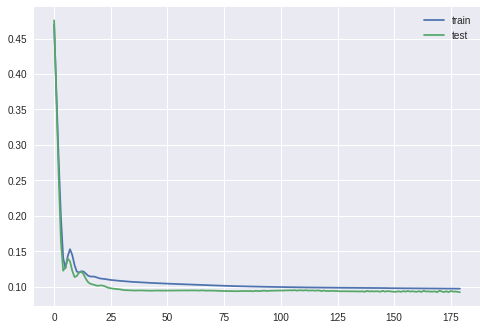

In [71]:
import matplotlib.pyplot as plt 
model = Sequential()
model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

history = model.fit(train_X, train_y, epochs=180, batch_size=200, validation_data=(test_X, test_y), verbose=2, shuffle=False)

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [0]:
# #from sklearn.externals import joblib

# #joblib.dump(model, '/Users/jxu2/github/thesis_explorations/life_support/predictor/LSTM_mood_predictor.pkl') 
# model.save('my_model.h5')  


In [0]:
# from google.colab import files
# files.download('my_model.h5')

In [72]:
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# make a prediction
yhat = DataFrame(model.predict(test_X))
test_X = DataFrame(test_X.reshape((test_X.shape[0], test_X.shape[2])))
# invert scaling for forecast
inv_yhat = concat((yhat, test_X.iloc[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = DataFrame(test_y.reshape((len(test_y), 1)))
inv_y = concat((test_y, test_X.iloc[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)
print('r-squared: %f'%(r2_score(inv_y, inv_yhat)))

Test RMSE: 0.471
r-squared: 0.012433


In [0]:
model.save('LSTM_mood_predictor_no_reporter.h5')  


In [0]:
from google.colab import files
files.download('LSTM_mood_predictor_no_reporter.h5')

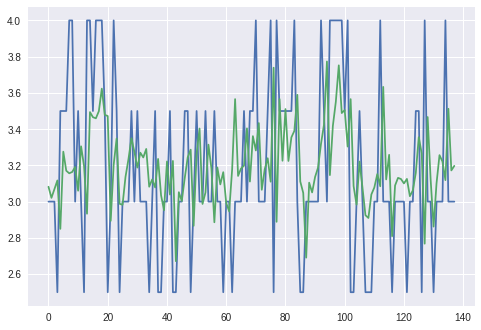

In [62]:
plt.plot(inv_y)
plt.plot(inv_yhat)